# 🔹 B. Distance-Based Models  
## 2. K-Nearest Neighbors (KNN)

---

**What this notebook covers (high level):**

- 🧠 **Intuition and step-by-step algorithm** for KNN (classification & regression)  
- 📏 **Distance metrics and equations**  
- ⚖️ **Weighted and unweighted KNN**  
- 🔧 **Practical considerations:** scaling, complexity, choice of $k$  
- 🎨 **Examples with visualizations:**  
  - 2D classification (**decision boundary**)  
  - 2D regression  
- 🛠️ **Using `scikit-learn`** (`KNeighborsClassifier`, `KNeighborsRegressor`)  
- 🏗️ **Building a KNN class from scratch** (vectorized NumPy implementation)  
- 🎯 **Hyperparameter selection** (cross-validation)  
- ⚡ **Pros, cons, and tips**

---

We'll move **from intuition to implementation** with **visualizations** that make behavior clear.


# 🧠 KNN Intuition & Step-by-Step Description

---

## 🔹 Intuition

KNN is a **simple, instance-based (lazy) learning algorithm**:

- **Classification:** predict the label of a query point by looking at the labels of the $k$ **closest training points** and taking a (possibly **weighted**) majority vote.  
- **Regression:** predict the value by **averaging** (possibly weighted) the target values of the $k$ nearest neighbors.

---

## 🔹 Step-by-Step Algorithm (Classification)

1. Choose a **distance metric** $d$ (e.g., Euclidean).  
2. Choose **$k$** (number of neighbors).  
3. For a **query point** $x_{\text{query}}$:  
   - Compute distances $d(x_{\text{query}}, x_i)$ for each training sample $x_i$.  
   - Select the **$k$ training points** with the smallest distances.  
   - Aggregate their **labels** (majority vote or weighted vote) → predicted label.

---

## 🔹 Step-by-Step Algorithm (Regression)

- Same as classification, but aggregate by **mean** or **weighted mean** of the neighbor target values.

---

## 🔹 Important Notes

- KNN is **lazy**: no explicit training model (except storing training data).  
- Sensitive to **feature scales** → **always scale** numeric features (e.g., `StandardScaler`).  
- Choice of **$k$**:  
  - Small $k$ → **high variance** (overfitting)  
  - Large $k$ → **high bias** (smooth predictions)


# 📐 KNN Key Equations: Distances & Weighting

---

## 🔹 Distance Metrics

- **Euclidean (L2):**  
$$
d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{j=1}^p (x_j - y_j)^2}
$$

- **Manhattan (L1):**  
$$
d(\mathbf{x}, \mathbf{y}) = \sum_{j=1}^p |x_j - y_j|
$$

- **Minkowski (general)** with parameter $p$:  
$$
d(\mathbf{x}, \mathbf{y}) = \left(\sum_{j=1}^p |x_j - y_j|^p \right)^{1/p}
$$

---

## 🔹 Weighting

- **Uniform:** each neighbor contributes equally.  
- **Inverse-distance weighting:**  
$$
w_i = \frac{1}{d_i + \epsilon}
$$
*(small $\epsilon$ avoids division by zero)*  

- **Gaussian-like weighting:**  
$$
w_i = \exp\left(-\frac{d_i^2}{2\sigma^2}\right)
$$

---

## 🔹 Classification Prediction (Weighted Majority)

Let neighbors have labels $y_i \in \mathcal{C}$. For class $c$:  
$$
\text{score}(c) = \sum_{i \in \text{neighbors}} w_i \cdot \mathbf{1}\{y_i = c\}
$$
Predicted class:  
$$
\hat{y} = \arg\max_c \text{score}(c)
$$

---

## 🔹 Regression Prediction (Weighted Average)

Given neighbor targets $y_i$ and weights $w_i$:  
$$
\hat{y} = \frac{\sum_{i} w_i \, y_i}{\sum_{i} w_i}
$$`
- For **uniform weights** $w_i = 1$, this reduces to the simple mean.


# ⏱️ When to Use KNN & Its Complexity

---

## 🔹 When to Use KNN

- 📊 **Small to medium datasets** (fits in memory)  
- 🔍 **Irregular decision boundaries** or when local structure matters  
- ⚡ **Simple baseline** for comparison with other models

---

## 🔹 Complexity

- **Training time:** $O(1)$ — just store the data  
- **Prediction time:** $O(n \cdot p)$ per query (compute distances to all $n$ training points with $p$ features)  
- **Space:** $O(n \cdot p)$  
- Can accelerate with **KD-trees** or **Ball trees** for low to moderate dimensions  
  *(note: these degrade in high dimensions)*

---

## 🔹 Curse of Dimensionality

- In **high dimensions**, distances become less meaningful  
- KNN performance typically **degrades** unless you perform **dimensionality reduction** or **feature selection**


In [ ]:
# Cell 5 — Imports and utilities

# We'll import the standard libs and set plotting defaults.
# (Run this as Python cell.)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_blobs, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import seaborn as sns

# make visuals consistent
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (7, 5)


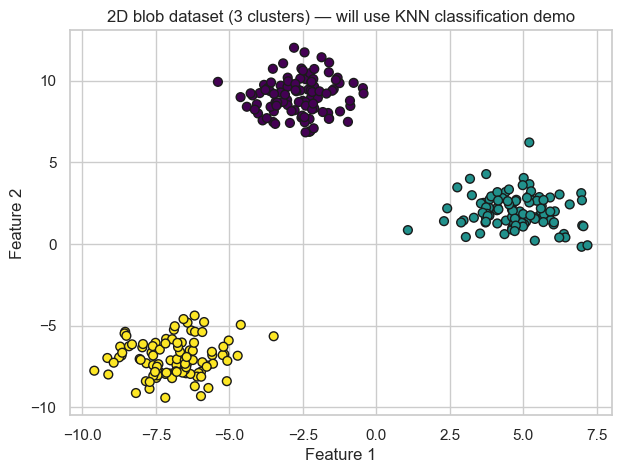

In [2]:
# Cell 7 — generate and plot blobs (classification demo)
X, y = make_blobs(n_samples=300, centers=3, cluster_std=1.1, random_state=42)
# Keep only two classes to demo binary classification (optional)
# For multi-class KNN the approach is identical.
plt.figure()
scatter = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=40, edgecolor='k')
plt.title("2D blob dataset (3 clusters) — will use KNN classification demo")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


# 🎨 Visualizing Decision Boundary Function (Helper)

---

We'll write a **helper function** to **plot KNN decision boundaries** for any model with a `predict` method.  

- Creates a **mesh grid** over the feature space  
- Colors regions by **predicted class**  
- Useful for **visualizing classification behavior** in 2D datasets


In [3]:
# Cell 9 — decision boundary plotting helper
def plot_decision_boundary(model, X, y, ax=None, title=None, cmap='viridis', eps=0.5, mesh_step=0.1):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,5))
    # compute mesh
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step),
                         np.arange(y_min, y_max, mesh_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolor='k', s=40)
    ax.set_title(title if title is not None else "Decision boundary")
    return ax


# 🛠️ KNN with scikit-learn (Classification) & Decision Boundary

---

We'll fit **scikit-learn's `KNeighborsClassifier`** for different **$k$ values** and **visualize the decision boundaries**.  

- Compare how **small vs large $k$** affects the smoothness and complexity of the boundary  
- Helps illustrate the **bias-variance trade-off** in KNN


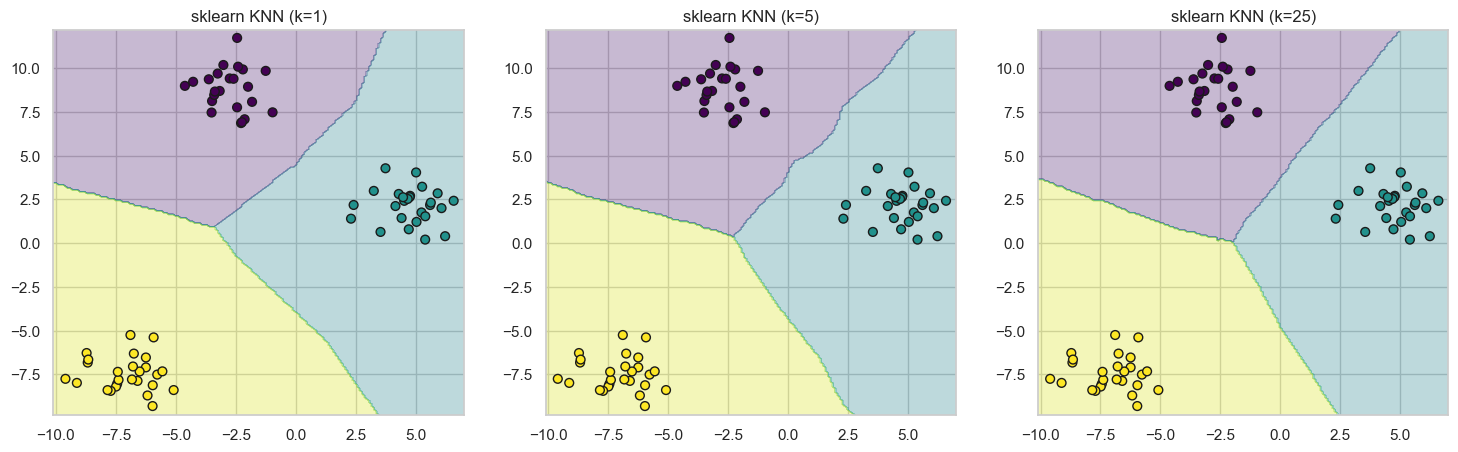

In [4]:
# Cell 11 — sklearn KNN decision boundaries for k=1,3,9
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, k in zip(axes, [1, 5, 25]):
    # Important: scale features because KNN sensitive to scaling (here features are on same scale but good habit)
    model = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=k))])
    model.fit(X_train, y_train)
    plot_decision_boundary(model, X_test, y_test, ax=ax, title=f"sklearn KNN (k={k})")
plt.show()


# 🔍 Observations: Effect of $k$

---

### Key Points After Visualizing Decision Boundaries

- **$k = 1$**: boundary is very **wiggly** → **high variance**  
  *(each training point defines a small region)*

- **$k \approx 5$ (moderate)**: smoother boundaries → good **bias-variance trade-off**

- **$k = 25$ (large)**: boundary is **very smooth** → may **underfit** → **high bias**

> ⚠️ **Always choose $k$ via cross-validation** to balance bias and variance.


# 🏗️ KNN From Scratch (Vectorized, Classification & Regression)

---

We'll implement a **KNN class** with the following features:

- `fit(X, y)` — store training data  
- `predict(X_query)` — supports both **classification** and **regression**  
- Supports **weighting schemes**: `'uniform'` and `'distance'`  
- Supports **Minkowski distance** with parameter $p$ (`p=2` is Euclidean)  

> ⚡ Implementation will be **vectorized with NumPy** for speed  
> *(still $O(n)$ per query since we compute distances to all training points)*


In [5]:
# Cell 14 — KNN from scratch (class)
import numpy as np
from collections import Counter

class MyKNN:
    def __init__(self, n_neighbors=5, weights='uniform', p=2, task='classification', eps=1e-8):
        """
        n_neighbors: int
        weights: 'uniform' or 'distance' or callable(distances) -> weights
        p: Minkowski p (1 -> manhattan, 2 -> euclidean)
        task: 'classification' or 'regression'
        eps: small number to avoid division by zero for distance weights
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self.task = task
        self.eps = eps
    
    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)
        # store classes for classification
        if self.task == 'classification':
            self.classes_ = np.unique(self.y_train)
        return self
    
    def _minkowski_distances(self, X):
        # returns distance matrix shape (n_queries, n_train)
        # fast vectorized computation using broadcasting
        # For memory efficiency we do pairwise calculation in vectorized loop if needed
        X = np.asarray(X)
        # shape: (n_queries, 1, p) - (1, n_train, p) -> (n_queries, n_train, p)
        # then take absolute power p, sum over axis=2, then **(1/p)
        # But to avoid big memory blowup for huge datasets, user should be aware.
        diff = np.abs(X[:, None, :] - self.X_train[None, :, :]) ** self.p
        distances = np.sum(diff, axis=2) ** (1 / self.p)
        return distances
    
    def _get_weights(self, distances):
        # distances shape (n_queries, k)
        if self.weights == 'uniform':
            w = np.ones_like(distances)
        elif self.weights == 'distance':
            w = 1.0 / (distances + self.eps)
        elif callable(self.weights):
            w = self.weights(distances)
        else:
            raise ValueError("weights must be 'uniform', 'distance', or callable")
        return w
    
    def predict(self, X):
        X = np.asarray(X)
        distances = self._minkowski_distances(X)  # (n_q, n_train)
        # argsort
        idx = np.argsort(distances, axis=1)[:, :self.n_neighbors]  # (n_q, k)
        neigh_dist = np.take_along_axis(distances, idx, axis=1)  # (n_q, k)
        neigh_y = self.y_train[idx]  # (n_q, k)
        weights = self._get_weights(neigh_dist)  # (n_q, k)
        
        if self.task == 'classification':
            # weighted vote
            preds = []
            for labels_row, w_row in zip(neigh_y, weights):
                class_scores = {}
                for lab, w in zip(labels_row, w_row):
                    class_scores[lab] = class_scores.get(lab, 0.0) + float(w)
                # pick class with highest score
                pred = max(class_scores.items(), key=lambda kv: kv[1])[0]
                preds.append(pred)
            return np.array(preds)
        elif self.task == 'regression':
            # weighted average
            # If uniform weights, weights may be ones -> mean
            numer = np.sum(weights * neigh_y, axis=1)
            denom = np.sum(weights, axis=1)
            # denom should not be zero because weights > 0
            return numer / denom
        else:
            raise ValueError("task must be 'classification' or 'regression'")
    
    def score(self, X, y_true):
        y_pred = self.predict(X)
        if self.task == 'classification':
            return np.mean(y_pred == y_true)
        else:
            return -np.mean((y_pred - y_true) ** 2)  # negative MSE like sklearn's score style


# ⚡ Quick Test: `MyKNN` vs scikit-learn on 2D Blob Dataset

---

We'll fit our **`MyKNN`** implementation and **scikit-learn's `KNeighborsClassifier`**, then compare **accuracy on the test set**.  

- Helps verify that our **from-scratch implementation** produces results comparable to sklearn  
- Useful for **debugging and validating correctness**


In [7]:
# Cell 16 — compare implementations
# scale features first (good practice)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# sklearn
sk_model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
sk_model.fit(X_train_s, y_train)
sk_pred = sk_model.predict(X_test_s)
sk_acc = accuracy_score(y_test, sk_pred)

# our implementation
my_knn = MyKNN(n_neighbors=5, weights='uniform', p=2, task='classification')
my_knn.fit(X_train_s, y_train)
my_pred = my_knn.predict(X_test_s)
my_acc = accuracy_score(y_test, my_pred)

sk_acc, my_acc


(1.0, 1.0)

# 🎨 Visualize `MyKNN` Decision Boundary (From-Scratch Model)

---

We'll plug our **`MyKNN`** implementation into the **decision boundary plotting helper**.  

- Note: the helper expects `model.predict(X)`, which our class supports ✅  
- We'll create a **pipeline manually**: scale inputs → feed into our classifier  
- Allows **direct comparison** with scikit-learn KNN boundaries


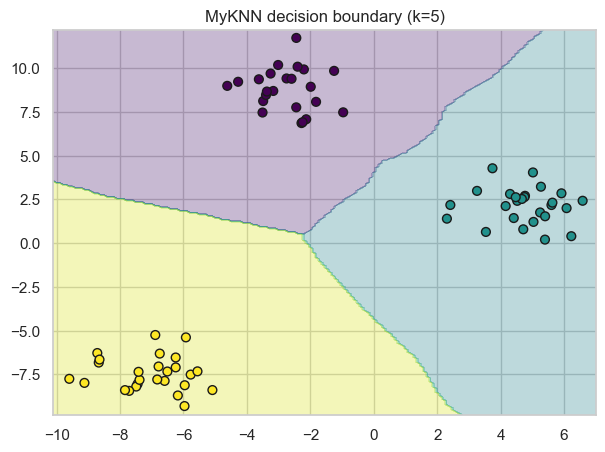

In [8]:
# Cell 18 — plot decision boundary for our MyKNN
# We'll define a small wrapper object with predict that scales inputs before calling MyKNN.
class WrappedMyKNN:
    def __init__(self, knn, scaler):
        self.knn = knn
        self.scaler = scaler
    def predict(self, X):
        Xs = self.scaler.transform(X)
        return self.knn.predict(Xs)

# train our model (already trained), wrap it
wrapped = WrappedMyKNN(my_knn, scaler)
plot_decision_boundary(wrapped, X_test, y_test, title="MyKNN decision boundary (k=5)")
plt.show()


# 📈 KNN Regression Demo (scikit-learn & From-Scratch)

---

We'll create a **1D input + noisy target** dataset and visualize how **$k$ affects smoothing** and regression predictions.

- Dataset options: `make_regression` or a simple **sine + noise** function  
- Compare **scikit-learn `KNeighborsRegressor`** vs **`MyKNN` regression mode**  
- Illustrates **bias-variance trade-off** in regression


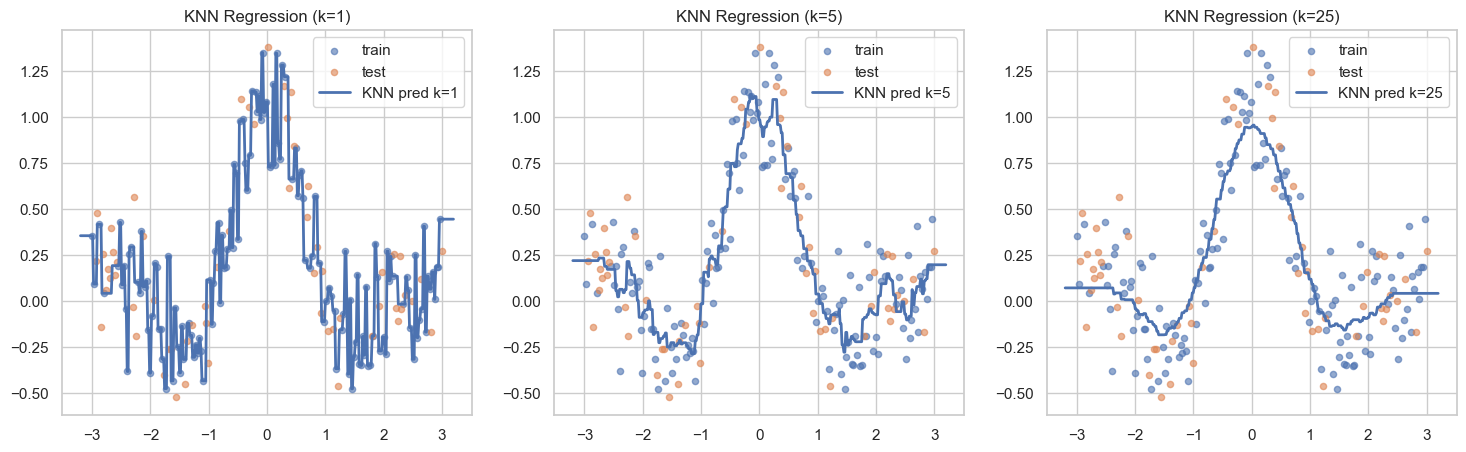

In [9]:
# Cell 20 — regression dataset and plot
np.random.seed(0)
X_reg = np.linspace(-3, 3, 200).reshape(-1,1)
y_reg = np.sinc(X_reg[:,0]) + 0.2 * np.random.randn(X_reg.shape[0])

# split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=2)

# fit sklearn KNeighborsRegressor with different k and plot
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, k in zip(axes, [1,5,25]):
    model = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=k, weights='uniform'))])
    model.fit(Xr_train, yr_train)
    X_grid = np.linspace(X_reg.min()-0.2, X_reg.max()+0.2, 400).reshape(-1,1)
    y_pred = model.predict(X_grid)
    ax.scatter(Xr_train, yr_train, s=20, label='train', alpha=0.6)
    ax.scatter(Xr_test, yr_test, s=20, label='test', alpha=0.6)
    ax.plot(X_grid, y_pred, label=f'KNN pred k={k}', linewidth=2)
    ax.set_title(f'KNN Regression (k={k})')
    ax.legend()
plt.show()


# ⚖️ Weighted vs Uniform KNN (Classification)

---

**Weighted KNN** (inverse-distance) gives **closer neighbors more influence**.  

- Helpful when neighbors have **varying distances**  
- We'll compare **decision boundaries** with:  
  - `weights='uniform'` → all neighbors contribute equally  
  - `weights='distance'` → closer neighbors contribute more  

- Example: **$k=5$**, visualize effect on classification regions


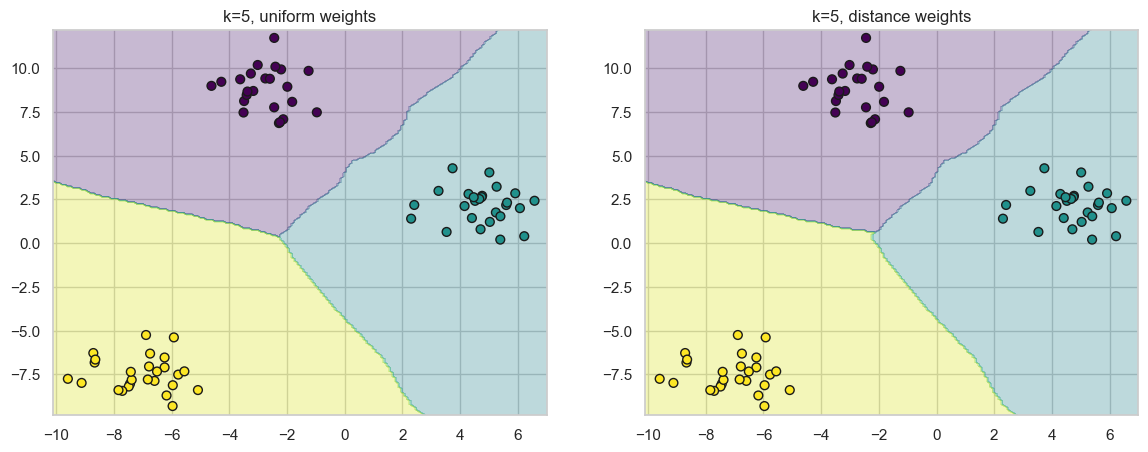

In [10]:
# Cell 22 — weighted vs uniform decision boundary
fig, axes = plt.subplots(1, 2, figsize=(14,5))
models = [
    Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5, weights='uniform'))]),
    Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))])
]
titles = ['uniform weights', 'distance weights']
for ax, model, title in zip(axes, models, titles):
    model.fit(X_train, y_train)
    plot_decision_boundary(model, X_test, y_test, ax=ax, title=f'k=5, {title}')
plt.show()


# 🎯 Choosing $k$: Cross-Validation & Grid Search

---

We'll use **cross-validation** to select the optimal **$k$** for KNN.

- Search over **odd $k$ values** to avoid ties in classification  
- Evaluate **CV accuracy** for each $k$  
- Implementation via **scikit-learn's `GridSearchCV`**  

> ⚡ Helps systematically balance **bias-variance trade-off** and pick the best $k$ for your dataset


In [11]:
# Cell 24 — Grid search for best k
param_grid = {'knn__n_neighbors': list(range(1,31,2))}
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)
# show CV results succinctly
cv_results = gs.cv_results_
k_list = param_grid['knn__n_neighbors']
mean_scores = [cv_results['mean_test_score'][i] for i in range(len(k_list))]
import pandas as pd
pd.DataFrame({'k': k_list, 'mean_cv_accuracy': mean_scores})


Best params: {'knn__n_neighbors': 1}
Best CV score: 1.0


,k,mean_cv_accuracy
0,1,1.0
1,3,1.0
2,5,1.0
3,7,1.0
4,9,1.0
5,11,1.0
6,13,1.0
7,15,1.0
8,17,1.0
9,19,1.0


# ⚖️ Importance of Data Scaling in KNN

---

We'll create an **artificial dataset** where features have **different scales** to demonstrate how **scaling affects KNN predictions**.

- KNN is **distance-based**, so features with larger scales dominate the distance metric  
- Use **StandardScaler** or **MinMaxScaler** to bring all features to comparable scales  
- Visualize **decision boundaries before and after scaling**


In [12]:
# Cell 26 — scaling effects demo
np.random.seed(42)
# feature 1 small range, feature 2 large range
X_a = np.random.randn(300, 2)
X_a[:,1] = X_a[:,1] * 50  # scale second feature up
y_a = (X_a[:,0] + X_a[:,1]/50 > 0).astype(int)  # label dependent on combination

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.3, random_state=0)

model_no_scale = KNeighborsClassifier(n_neighbors=5)
model_no_scale.fit(X_train_a, y_train_a)
acc_no_scale = model_no_scale.score(X_test_a, y_test_a)

pipe_scaled = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))])
pipe_scaled.fit(X_train_a, y_train_a)
acc_scaled = pipe_scaled.score(X_test_a, y_test_a)

acc_no_scale, acc_scaled


(0.7777777777777778, 0.9888888888888889)

# 📊 Summary: Effect of Scaling on KNN

---

- **Observation:** Scaling generally **improves KNN performance** when features have different numeric ranges  
- **Reason:** Without scaling, distance computations give **disproportionate weight** to features with larger scales  
- Proper scaling ensures that **all features contribute fairly** to neighbor selection


# ⚡ KNN Complexity & Acceleration Tips

---

### Complexity Recap
- **Naive prediction:** $O(n_{\text{train}} \cdot p)$ per query  
- **Acceleration:**  
  - Use **KD-tree** or **Ball-tree** (supported in scikit-learn) for low-to-medium dimensions  
  - For high-dimensional data, use **Approximate Nearest Neighbor (ANN)** methods: **FAISS**, **Annoy**, **HNSW**

### Practical Tips
- ✅ **Always scale features** (StandardScaler or MinMaxScaler)  
- ✅ **Use cross-validation** to choose $k$  
- ✅ Experiment with **distance metrics** ($p=1$ vs $p=2$)  
- ✅ Consider **distance-based weighting** if closer neighbors are more relevant


# ✅❌ KNN: Pros & Cons

---

### Pros
- ✅ **Simple to implement and understand**  
- ✅ **Non-parametric** → flexible decision boundaries  
- ✅ Works well with **enough representative data** and **low feature dimensionality**

### Cons
- ❌ **Prediction cost and memory usage** scale with dataset size  
- ❌ **Sensitive to irrelevant features and feature scaling**  
- ❌ Performance degrades in **high-dimensional spaces** (curse of dimensionality)  
- ❌ Requires careful choice of **$k$** and **distance metric**


# 📝 Practical Checklist When Using KNN

---

1. 🔹 **Preprocess data**: handle missing values, encode categorical features properly (KNN typically uses numeric features)  
2. 🔹 **Scale numeric features**: StandardScaler or MinMaxScaler  
3. 🔹 **Choose distance metric**: Euclidean ($p=2$) by default; consider Manhattan ($p=1$) for sparse/high-dimensional data  
4. 🔹 **Select $k$ via cross-validation**: prefer odd values for binary classification to avoid ties  
5. 🔹 **Consider weighting scheme**: `'distance'` often helps when neighbor distances vary  
6. 🔹 **Acceleration for large datasets**: use KD-tree/Ball-tree or Approximate Nearest Neighbor libraries (FAISS, Annoy, HNSW)  
7. 🔹 **Evaluate performance**: use appropriate metrics (accuracy, F1 for classification; MSE for regression)


# 🛠️ How scikit-learn Implements KNN (Brief)

---

**scikit-learn provides:**

- `KNeighborsClassifier` & `KNeighborsRegressor`  
  - Naive (brute-force) or KD/ Ball-tree based neighbor search  
  - Supports `weights='uniform' | 'distance' | callable`  

- `RadiusNeighbors` variants  
  - Find neighbors within a fixed radius instead of a fixed $k$  

- **Performance tuning:**  
  - `algorithm='auto' | 'ball_tree' | 'kd_tree' | 'brute'`  
  - `leaf_size` for tree-based algorithms  


✅ Features:  
- Emojis for clarity (`🛠️`).  
- Bold highlights for key options and parameters (`weights`, `$k$`, `algorithm`).  
- Code block separated for clear visual distinction.  

I can now **create a final polished summary/conclusion cell for the KNN notebook** to wrap it all up. Do you want me to do that?


# 📚 KNN: Closing Notes & Further Reading

---

### Further Reading & Practice
- 🔹 Try KNN on a **real dataset**: Iris, Wine, or any tabular dataset  
- 🔹 Explore **KD-tree vs Ball-tree** performance in scikit-learn  
- 🔹 Experiment with **approximate nearest neighbor libraries** for large datasets: FAISS, Annoy  
- 🔹 Combine KNN with **dimensionality reduction** (PCA, UMAP) before distance computation for high-dimensional problems  

---

**✅ End of Notebook**  
You now have both a **conceptual and practical grasp** of KNN, a **from-scratch implementation**, and **visualization code** to experiment with.
